### 12 Jan 2023

### Elena Savidge, with help from Dr. Tasha Snow

# Fig. 1 code.

In [80]:
# load packages
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import cmocean
import scipy
from scipy import ndimage
import cartopy.crs as ccrs
import numpy as np
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pyproj
import cartopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib.collections import PatchCollection

# need this line for pyproj to work on my machine
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/sealenv/share/proj') 

### Fig. 1 Top Row (seal data)

# 2014 

### 1. Read seal data

In [83]:
# To read from pickle after already created 
seal14 = pd.read_pickle('seal14_file')

In [84]:
# keep all surface measurements (here upper 20 m of water column -- to be later averaged for plotting), in lat/lon bounds of interest
surf = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-76 < LATITUDE < -70.5 & -106.5 < LONGITUDE < -98.4 & 0.0 <= z <= 20.0')

# separate by winter months of dense sampling (for this work: May to August). mjja = may-june-july-august
mjja14 = surf[(surf['Datetime']>='2014-5-1') & (surf['Datetime']<'2014-9-1')] 

### 2. Read in MODIS image (for figure background)

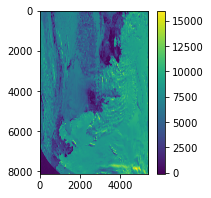

In [85]:
# read in background modis visible image (download from: https://search.earthdata.nasa.gov/search/granules?projectId=6303123459)
MODfiles = glob('../MODIS/2014/Optical/MOD09.A2014073.1410.061.2021249131512.hdf') 

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# Show entire MODIS image (preview)
fig,ax = plt.subplots(figsize=(3,3))
plt.imshow(B1)
plt.colorbar()

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

### 3. Read in basal channel shapefiles (from Alley et al., 2016)

In [110]:
# load basal channel shapefiles (from Alley et al., 2016)
shapefile1 = gpd.read_file('../basal_channels/gls_channels_shape.shp')
shapefile2 = gpd.read_file('../basal_channels/os_channels_shape.shp')
shapefile3 = gpd.read_file('../basal_channels/p_channels_shape.shp')
shapefile4 = gpd.read_file('../basal_channels/sgs_channels_shape.shp')

# convert coordinate system (utm to latlon)
shapefile1 = shapefile1.to_crs("epsg:4326")
shapefile2 = shapefile2.to_crs("epsg:4326")
shapefile3 = shapefile3.to_crs("epsg:4326")
shapefile4 = shapefile4.to_crs("epsg:4326")

### 4. Plot the seal data overlaying MODIS image

In [87]:
# define variables of interests x,y,z = lat,lon,temperature
data1 = mjja14
#data = data1.groupby('Datetime').mean() # get surface means (upper 20 m defined above), grouped by datetime (e.g., for each dive that has distinct date and time)
data = data1.groupby(['LATITUDE', 'LONGITUDE'],as_index=False).agg({'CT': 'mean'}) # get surface means (upper 20 m defined above)
#data['Max z'] = (data1.groupby('Datetime').max())['z']
vbl = 'CT'
data = data[data[vbl].notna()]
y = data['LATITUDE']
x = data['LONGITUDE']
z = data[vbl]

In [88]:
from shapely.geometry import Point, Polygon
# read in coastline from https://data.bas.ac.uk/items/e46be5bc-ef8e-4fd5-967b-92863fbe2835/#item-details-citation
coastline = '../add_coastline_high_res_polygon_v7.2.wgs.shp'

p1 = Point(-110, -70.5)
p2 = Point(-111.7, -75.4)
p3 = Point(-98.0, -75.4)
p4 = Point(-99.5, -70.5)

np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

bb_polygon = Polygon([np1, np2, np3, np4])
map_extent = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])

shelf = gpd.read_file(coastline)
shelf_clip = gpd.clip(shelf,map_extent)
shelf_clip = shelf_clip[~shelf_clip.is_empty]
land = shelf_clip.loc[shelf_clip['surface'] == 'land']
ice = shelf_clip.loc[shelf_clip['surface'] == 'ice shelf']

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_8636/4294618917.py:19: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: None

  shelf_clip = gpd.clip(shelf,map_extent)


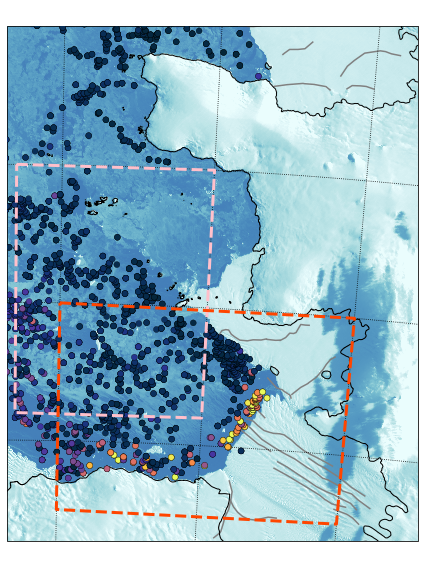

In [90]:
# Plot surface reflectance/temperature

# Define variable bounds
if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
elif vbl=='CT': vmin = -1.9;vmax=-1.2

# lat/lon bounds
llcrnrlat=-75.3;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal
fig,ax = plt.subplots(figsize=(6,8)) # give two axes 
plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
m.add_geometries(land['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='k', zorder=2) # grounding line
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = gl.top_labels = gl.left_labels = False

# Plot data (modis and seal)
data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=-10000,vmax=10000)
dataseal = m.scatter(x,y,c=z,cmap=cmocean.cm.thermal,vmax=vmax,vmin=vmin,edgecolor='k',linewidth= 0.3,transform=ccrs.PlateCarree(),zorder=3) 

# basal channels (from Alley et al., 2016)
m.add_geometries(shapefile1['geometry'], crs=ccrs.PlateCarree(),facecolor='none', edgecolor = 'gray',linewidth=1.5)
m.add_geometries(shapefile2['geometry'], crs=ccrs.PlateCarree(),facecolor='none', edgecolor = 'gray',linewidth=1.5)
m.add_geometries(shapefile3['geometry'], crs=ccrs.PlateCarree(),facecolor='none',edgecolor = 'gray',linewidth=1.5)
m.add_geometries(shapefile4['geometry'], crs=ccrs.PlateCarree(),facecolor='none',edgecolor = 'gray',linewidth=1.5)

# Add bounding boxes (can comment this out)
# 1
patches = []
zone = np.array([[-104,-74.5],[-100,-74.5],[-100,-75.25],[-104,-75.25]])
patches.append(Polygon(zone))
#m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5))
m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5)
# 2
patches = []
zone = np.array([[-104.6,-74],[-102,-74],[-102,-74.9],[-104.6,-74.9]])
patches.append(Polygon(zone))
m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='pink', linewidths=3, linestyle='dashed',zorder=4)

# Colorbar seal CT
# cb = plt.colorbar(dataseal,ticks=[-1.8,-1.6,-1.4,-1.2],fraction=0.045,pad=0.03,orientation='horizontal')
# cb.ax.set_yticklabels(cb.ax.get_yticklabels())
# cb.outline.set_edgecolor('k')
# cb.outline.set_linewidth(1)
# cb.ax.tick_params(color='k',size=5,labelsize=12)
# cb.set_label('Seal-borne temperature [C]',rotation=0,fontsize=16,labelpad=5)

plt.tight_layout()

plt.savefig('fig12014_updated.png', format='png', dpi=400)

### Ok so that's the top row for 2014 data. Now let's plot the thermal data for the bottom row of fig. 1.

In [85]:
# Read in a clear MODIS image (can quickly visualize here: https://worldview.earthdata.nasa.gov/?v=-1698802.8137315765,-363310.3951540059,-1523570.8137315765,-278958.3951540059&r=101.251&p=antarctic&z=2&l=MODIS_Terra_Brightness_Temp_Band31_Day(hidden,min=227.6,max=256.5,squash=true),Coastlines_15m(hidden),MODIS_Aqua_Brightness_Temp_Band31_Night(hidden),MODIS_Aqua_Brightness_Temp_Band31_Day(hidden,min=243.3,max=264,squash=true),MODIS_Terra_Brightness_Temp_Band31_Night(hidden),VIIRS_SNPP_CorrectedReflectance_TrueColor(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor&lg=false&t=2000-03-01-T15%3A23%3A33Z)
MODfiles = glob('../MODIS/2014/MYD09.A2014192*')

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15 # now we want thermal band
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [86]:
from matplotlib.patches import Polygon

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_74724/709480068.py:55: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(data,ticks=[-40,-35,-30,-25,-20,-15,-10,-5,0],fraction=0.045,pad=2.5,orientation='horizontal',shrink=0.84)


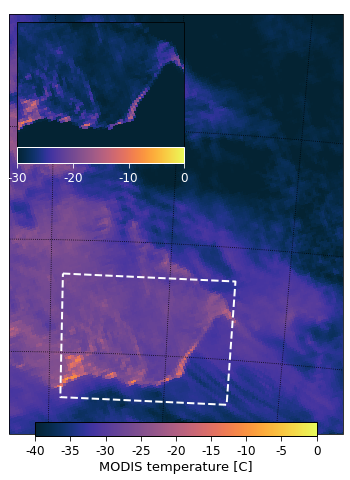

In [87]:
# Plot surface reflectance/temperature

if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
elif vbl=='CT': vmin = -1.9;vmax=-1.65

llcrnrlat=-75.3;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal

fig,ax = plt.subplots(figsize=(6,8)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = gl.top_labels = gl.left_labels= False

data = m.pcolormesh(lon,lat,B31,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-40,vmax=0,zorder=1)#vmin=-5.0,vmax=-2.5,

# inset
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=-105.0)))

ip = InsetPosition(ax,[0.025, 0.57, 0.5, 0.5]) #2014

axins.set_axes_locator(ip)
llcrnrlat=-75.2;urcrnrlat=-74.65;llcrnrlon=-103.8;urcrnrlon=-100.9 #2014
axins.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
zoom = axins.pcolormesh(lon,lat,B31, transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-30,vmax=0,zorder=2)

cax = inset_axes(axins,
                 width="100%",  # width = X% of parent_bbox width
                 height="12%",  # height : X%
                 loc='upper left',
                 bbox_to_anchor=(0.0005, -1, 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

cb3 = plt.colorbar(zoom,cax=cax,ticks=[-30,-20,-10,0],orientation='horizontal')#,shrink=0.9,fraction=0.045,pad=0.9)
cb3.ax.set_xticklabels(['-30','-20','-10','0'],color ='w')
cb3.outline.set_edgecolor('w')
cb3.outline.set_linewidth(1)
cb3.ax.tick_params(color='w',size=5,labelsize=12)
#cb3.set_label('MODIS temperature [C]',rotation=0,fontsize=12,labelpad=0.5,color='w')

# bbox profiles
llcrnrlat=-75.2;urcrnrlat=-74.65;llcrnrlon=-103.7;urcrnrlon=-100.9 #2014
patches = []
zone = np.array([[-103.8,-74.65],[-100.9,-74.65],[-100.9,-75.2],[-103.8,-75.2]]) #2014
patches.append(Polygon(zone))
m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='w', linewidths=2, linestyle='dashed',zorder=5))

# Colorbar (whole image) - comment out 
cb = plt.colorbar(data,ticks=[-40,-35,-30,-25,-20,-15,-10,-5,0],fraction=0.045,pad=2.5,orientation='horizontal',shrink=0.84)
cb.ax.set_xticklabels(['-40','-35','-30','-25','-20','-15','-10','-5','0'])
cb.ax.set_yticklabels(cb.ax.get_yticklabels())
cb.outline.set_edgecolor('k')
cb.outline.set_linewidth(1)
cb.ax.tick_params(color='k',size=5,labelsize=12)
cb.set_label('MODIS temperature [C]',rotation=0,fontsize=13,labelpad=2.5)

#plt.tight_layout()

#plt.savefig('X.png', format='png', dpi=400)

# 2019 

### 1. Read seal data

In [91]:
# To read from pickle after already created 
seal19 = pd.read_pickle('seal19_file')

In [92]:
# keep all surface measurements (here upper 20 m of water column -- to be later averaged for plotting), in lat/lon bounds of interest
surf = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-76 < LATITUDE < -70.5 & -106.5 < LONGITUDE < -98.4 & 0.0 <= z <= 20.0')

# separate by winter months of dense sampling (for this work: May to August). mjja = may-june-july-august
mjja19 = surf[(surf['Datetime']>='2019-5-1') & (surf['Datetime']<'2019-9-1')] 

### 2. Read in MODIS image (for figure background)

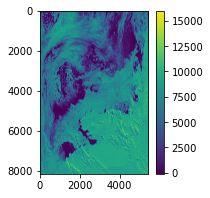

In [93]:
# read in background modis visible image (download from: https://search.earthdata.nasa.gov/search/granules?projectId=6303123459)
MODfiles = glob('../MODIS/2019/Optical/MOD09.A2019358.1505.006.2019360015909.hdf') # Dec 24

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# Show entire MODIS image (preview)
fig,ax = plt.subplots(figsize=(3,3))
plt.imshow(B1)
plt.colorbar()

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

### 3. Plot the seal data overlaying MODIS image

In [94]:
# define variables of interests x,y,z = lat,lon,temperature
data1 = mjja19
data = data1.groupby(['LATITUDE', 'LONGITUDE'],as_index=False).agg({'CT': 'mean'}) # get surface means (upper 20 m defined above), grouped by datetime (e.g., for each dive that has distinct date and time)
#data = data1.groupby('Datetime').mean() # Here some dives had non unique datetimes so this doesnt work
#data['Max z'] = (data1.groupby('Datetime').max())['z']
vbl = 'CT'
data = data[data[vbl].notna()]
y = data['LATITUDE']
x = data['LONGITUDE']
z = data[vbl]

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


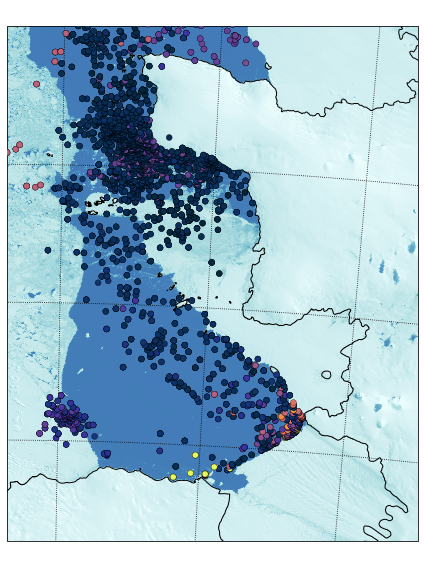

In [95]:
# Plot surface reflectance/temperature

# Define variable bounds
if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
elif vbl=='CT': vmin = -1.9;vmax=-1.2

# lat/lon bounds
llcrnrlat=-75.3;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal
fig,ax = plt.subplots(figsize=(6,8)) # give two axes 
plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
m.add_geometries(land['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='k', zorder=2) # grounding line
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = gl.left_labels = gl.top_labels = False

# Plot data (modis and seal)
data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=-10000,vmax=10000)
dataseal = m.scatter(x,y,c=z,cmap=cmocean.cm.thermal,vmax=vmax,vmin=vmin,edgecolor='k',linewidth= 0.3,transform=ccrs.PlateCarree(),zorder=3) 

# Colorbar seal CT
# cb = plt.colorbar(dataseal,ticks=[-1.8,-1.6,-1.4,-1.2],fraction=0.045,pad=0.03,orientation='horizontal')
# cb.ax.set_yticklabels(cb.ax.get_yticklabels())
# cb.outline.set_edgecolor('k')
# cb.outline.set_linewidth(1)
# cb.ax.tick_params(color='k',size=5,labelsize=12)
#cb.set_label('Seal-borne temperature [C]',rotation=0,fontsize=16,labelpad=5)

plt.tight_layout()

plt.savefig('fig12019_updated.png', format='png', dpi=400)

### Ok so that's the top row for 2019 data. Now let's plot the thermal data for the bottom row of fig. 1.

In [15]:
# Read in a clear MODIS image (can quickly visualize here: https://worldview.earthdata.nasa.gov/?v=-1698802.8137315765,-363310.3951540059,-1523570.8137315765,-278958.3951540059&r=101.251&p=antarctic&z=2&l=MODIS_Terra_Brightness_Temp_Band31_Day(hidden,min=227.6,max=256.5,squash=true),Coastlines_15m(hidden),MODIS_Aqua_Brightness_Temp_Band31_Night(hidden),MODIS_Aqua_Brightness_Temp_Band31_Day(hidden,min=243.3,max=264,squash=true),MODIS_Terra_Brightness_Temp_Band31_Night(hidden),VIIRS_SNPP_CorrectedReflectance_TrueColor(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor&lg=false&t=2000-03-01-T15%3A23%3A33Z)
MODfiles = glob('../MODIS/2019/MYD09.A2019138*')  # Aqua

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [14]:
from matplotlib.patches import Polygon

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_15333/1500137814.py:55: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(data,ticks=[-40,-35,-30,-25,-20,-15,-10,-5,0],fraction=0.045,pad=2.5,orientation='horizontal',shrink=0.84)


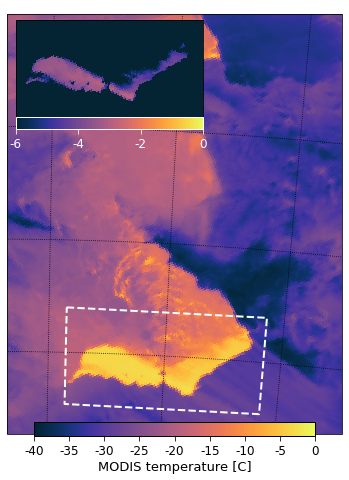

In [17]:
# Plot surface reflectance/temperature

if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
elif vbl=='CT': vmin = -1.9;vmax=-1.65

llcrnrlat=-75.3;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal

fig,ax = plt.subplots(figsize=(6,8)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = gl.top_labels = gl.left_labels= False

data = m.pcolormesh(lon,lat,B31,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-40,vmax=0,zorder=1)#vmin=-5.0,vmax=-2.5,

# inset
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=-105.0)))

ip = InsetPosition(ax,[0.025, 0.577, 0.56, 0.56]) #2019

axins.set_axes_locator(ip)
llcrnrlat=-75.22;urcrnrlat=-74.8;llcrnrlon=-103.7;urcrnrlon=-100.3 #2019
axins.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
zoom = axins.pcolormesh(lon,lat,B31, transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-6,vmax=0,zorder=2)

cax = inset_axes(axins,
                 width="100%",  # width = X% of parent_bbox width
                 height="12%",  # height : X%
                 loc='upper left',
                 bbox_to_anchor=(0.0005, -1, 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

# 2019
cb3 = plt.colorbar(zoom,cax=cax,ticks=[-6,-4,-2,0],orientation='horizontal')#,shrink=0.9,fraction=0.045,pad=0.9)
cb3.ax.set_xticklabels(['-6','-4','-2','0'],color ='w')
cb3.outline.set_edgecolor('w')
cb3.outline.set_linewidth(1)
cb3.ax.tick_params(color='w',size=5,labelsize=12)

# bbox profiles
llcrnrlat=-75.2;urcrnrlat=-74.65;llcrnrlon=-103.7;urcrnrlon=-100.9 #2014
patches = []
zone = np.array([[-103.7,-74.8],[-100.3,-74.8],[-100.3,-75.23],[-103.7,-75.23]]) #2019
patches.append(Polygon(zone))
m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='w', linewidths=2, linestyle='dashed',zorder=5))

# Colorbar (whole image) - comment out 
cb = plt.colorbar(data,ticks=[-40,-35,-30,-25,-20,-15,-10,-5,0],fraction=0.045,pad=2.5,orientation='horizontal',shrink=0.84)
cb.ax.set_xticklabels(['-40','-35','-30','-25','-20','-15','-10','-5','0'])
cb.ax.set_yticklabels(cb.ax.get_yticklabels())
cb.outline.set_edgecolor('k')
cb.outline.set_linewidth(1)
cb.ax.tick_params(color='k',size=5,labelsize=12)
cb.set_label('MODIS temperature [C]',rotation=0,fontsize=13,labelpad=2.5)

#plt.tight_layout()

#plt.savefig('X.png', format='png', dpi=400)

# 2020

### 1. Read seal data

In [101]:
# To read from pickle after already created 
seal20 = pd.read_pickle('seal20_file')

In [102]:
# keep all surface measurements (here upper 20 m of water column -- to be later averaged for plotting), in lat/lon bounds of interest
surf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-76 < LATITUDE < -70.5 & -106.5 < LONGITUDE < -98.4 & 0.0 <= z <= 20.0')

# separate by winter months of dense sampling (for this work: May to August). mjja = may-june-july-august
mjja20 = surf[(surf['Datetime']>='2020-5-1') & (surf['Datetime']<'2020-9-1')] 

### 2. Read in MODIS image (for figure background)

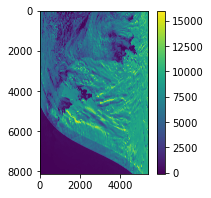

In [98]:
# read in background modis visible image (download from: https://search.earthdata.nasa.gov/search/granules?projectId=6303123459)
MODfiles = glob('../MODIS/2020/Optical/MOD09.A2020075.1455.006.2020077015510.hdf') 

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# Show entire MODIS image (preview)
fig,ax = plt.subplots(figsize=(3,3))
plt.imshow(B1)
plt.colorbar()

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

### 3. Plot the seal data overlaying MODIS image

In [103]:
# define variables of interests x,y,z = lat,lon,temperature
data1 = mjja20
# data = data1.groupby('Datetime').mean() # get surface means (upper 20 m defined above), grouped by datetime (e.g., for each dive that has distinct date and time)
data = data1.groupby(['LATITUDE', 'LONGITUDE'],as_index=False).agg({'CT': 'mean'}) #get surface means
# data['Max z'] = (data1.groupby('Datetime').max())['z']
vbl = 'CT'
data = data[data[vbl].notna()]
y = data['LATITUDE']
x = data['LONGITUDE']
z = data[vbl]

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


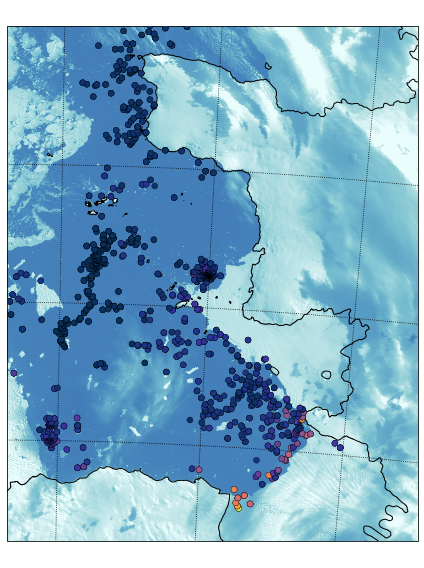

In [105]:
# Plot surface reflectance/temperature

# Define variable bounds
if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
elif vbl=='CT': vmin = -1.9;vmax=-1.2

# lat/lon bounds
llcrnrlat=-75.3;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal
fig,ax = plt.subplots(figsize=(6,8)) # give two axes 
plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
m.add_geometries(land['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='k', zorder=2) # grounding line
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = gl.left_labels = gl.top_labels = False

# Plot data (modis and seal)
data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=-10000,vmax=10000)
dataseal = m.scatter(x,y,c=z,cmap=cmocean.cm.thermal,vmax=vmax,vmin=vmin,edgecolor='k',linewidth= 0.3,transform=ccrs.PlateCarree(),zorder=3) 

# Colorbar seal CT
# cb = plt.colorbar(dataseal,ticks=[-1.8,-1.6,-1.4,-1.2],fraction=0.045,pad=0.03,orientation='horizontal')
# cb.ax.set_yticklabels(cb.ax.get_yticklabels())
# cb.outline.set_edgecolor('k')
# cb.outline.set_linewidth(1)
# cb.ax.tick_params(color='k',size=5,labelsize=12)
# cb.set_label('Seal-borne temperature [C]',rotation=0,fontsize=16,labelpad=5)

# patches = []
# zone = np.array([[-104,-74.5],[-100,-74.5],[-100,-75.25],[-104,-75.25]])
# patches.append(Polygon(zone))
# #m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5))
# m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5)
# 2

# patches = []
# zone = np.array([[-104.6,-74],[-102,-74],[-102,-74.9],[-104.6,-74.9]])
# patches.append(Polygon(zone))
# m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='pink', linewidths=3, linestyle='dashed',zorder=4)

plt.tight_layout()

#plt.savefig('fig12020_updated.png', format='png', dpi=400)

### Ok so that's the top row for 2020 data. Now let's plot the thermal data for the bottom row of fig. 1.

In [23]:
# Read in a clear MODIS image (can quickly visualize here: https://worldview.earthdata.nasa.gov/?v=-1698802.8137315765,-363310.3951540059,-1523570.8137315765,-278958.3951540059&r=101.251&p=antarctic&z=2&l=MODIS_Terra_Brightness_Temp_Band31_Day(hidden,min=227.6,max=256.5,squash=true),Coastlines_15m(hidden),MODIS_Aqua_Brightness_Temp_Band31_Night(hidden),MODIS_Aqua_Brightness_Temp_Band31_Day(hidden,min=243.3,max=264,squash=true),MODIS_Terra_Brightness_Temp_Band31_Night(hidden),VIIRS_SNPP_CorrectedReflectance_TrueColor(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor&lg=false&t=2000-03-01-T15%3A23%3A33Z)
MODfiles = glob('../MODIS/2020/MOD09.A2020154**')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [24]:
from matplotlib.patches import Polygon

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_15333/19958580.py:55: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(data,ticks=[-40,-35,-30,-25,-20,-15,-10,-5,0],fraction=0.045,pad=2.5,orientation='horizontal',shrink=0.84)


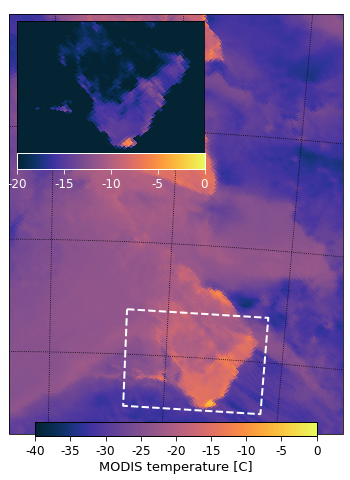

In [25]:
# Plot surface reflectance/temperature

if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
elif vbl=='CT': vmin = -1.9;vmax=-1.65

llcrnrlat=-75.3;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal

fig,ax = plt.subplots(figsize=(6,8)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = gl.top_labels = gl.left_labels= False

data = m.pcolormesh(lon,lat,B31,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-40,vmax=0,zorder=1)#vmin=-5.0,vmax=-2.5,

# inset
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=-105.0)))

ip = InsetPosition(ax,[0.025, 0.535, 0.56, 0.56]) #2020

axins.set_axes_locator(ip)
llcrnrlat=-75.22;urcrnrlat=-74.8;llcrnrlon=-102.7;urcrnrlon=-100.3 #2020
axins.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
zoom = axins.pcolormesh(lon,lat,B31, transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-20,vmax=0,zorder=2)

cax = inset_axes(axins,
                 width="100%",  # width = X% of parent_bbox width
                 height="12%",  # height : X%
                 loc='upper left',
                 bbox_to_anchor=(0.0005, -1, 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

# 2020
cb3 = plt.colorbar(zoom,cax=cax,ticks=[-20,-15,-10,-5,0],orientation='horizontal')#,shrink=0.9,fraction=0.045,pad=0.9)
cb3.ax.set_xticklabels(['-20','-15','-10','-5','0'],color ='w')
cb3.outline.set_edgecolor('w')
cb3.outline.set_linewidth(1)
cb3.ax.tick_params(color='w',size=5,labelsize=12)

# bbox profiles
llcrnrlat=-75.2;urcrnrlat=-74.65;llcrnrlon=-103.7;urcrnrlon=-100.9 #2014
patches = []
zone = np.array([[-102.7,-74.8],[-100.3,-74.8],[-100.3,-75.23],[-102.7,-75.23]]) #2020
patches.append(Polygon(zone))
m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='w', linewidths=2, linestyle='dashed',zorder=5))

# Colorbar (whole image) - comment out 
cb = plt.colorbar(data,ticks=[-40,-35,-30,-25,-20,-15,-10,-5,0],fraction=0.045,pad=2.5,orientation='horizontal',shrink=0.84)
cb.ax.set_xticklabels(['-40','-35','-30','-25','-20','-15','-10','-5','0'])
cb.ax.set_yticklabels(cb.ax.get_yticklabels())
cb.outline.set_edgecolor('k')
cb.outline.set_linewidth(1)
cb.ax.tick_params(color='k',size=5,labelsize=12)
cb.set_label('MODIS temperature [C]',rotation=0,fontsize=13,labelpad=2.5)

#plt.tight_layout()

#plt.savefig('X.png', format='png', dpi=400)

### 5. I save all panels and format for submission in illustrator or powerpoint :)

Screenshot of Fig. 1 from Savidge et al., 2023:

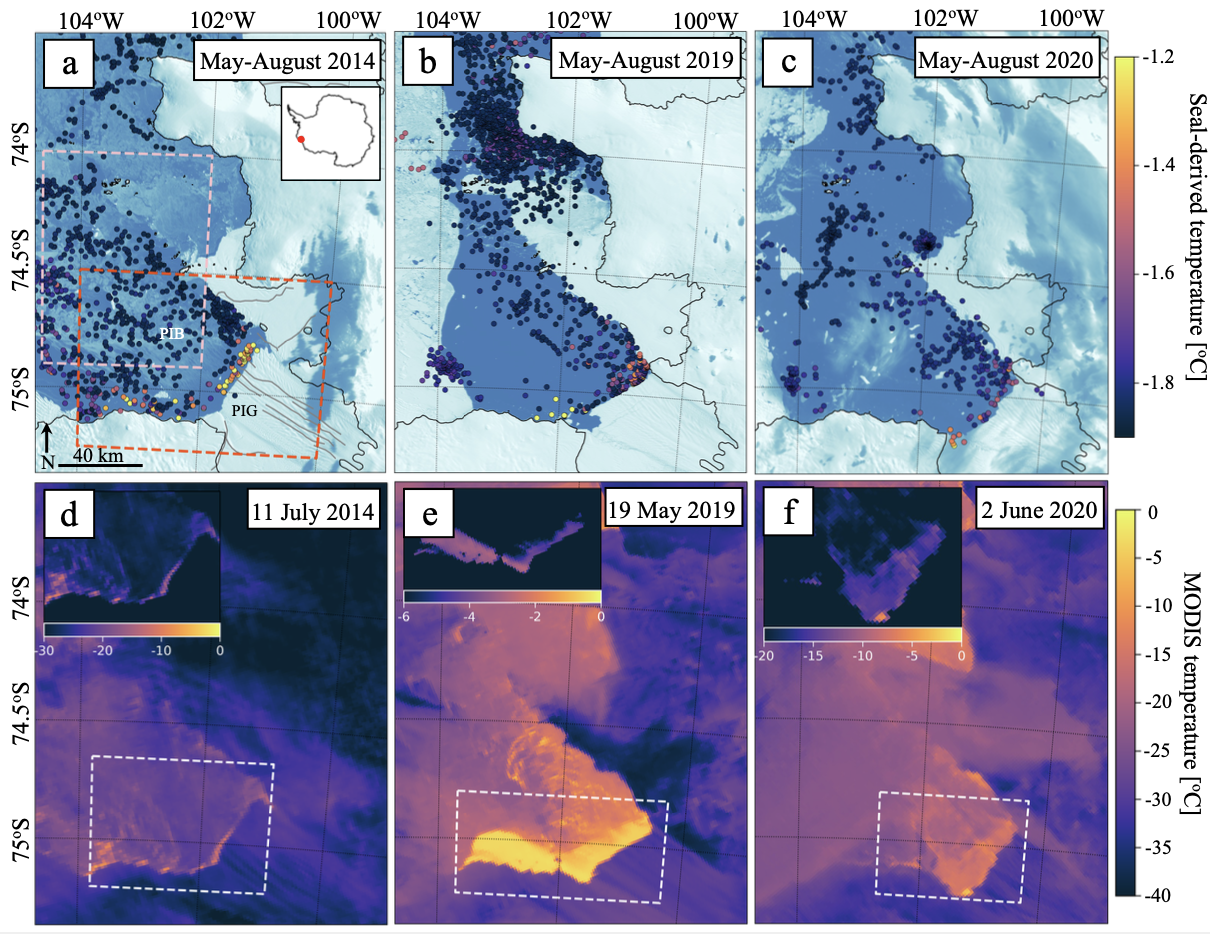

### ~ES